# Simple Multi-Agent App Example

## Overview
In this example, we'll explore how to build a **multi-agent application** where multiple specialized agents collaborate within a single system. Each agent is designed with a specific expertise, allowing the system to handle diverse types of requests efficiently.

## What We'll Build
We'll create two specialized agents:
- **Math Agent**: Handles mathematical computations (factorial, exponential, Fibonacci)
- **Music Agent**: Provides information about songs and artists

We'll explore more complex multi-agent workflows, but this tutorial focuses on the fundamentals.

## Architecture: Hierarchical Approach
This example uses a **hierarchical (router-based) architecture**, which is one of the simplest multi-agent patterns:

1. **Router/Manager**: Receives user requests and classifies them
2. **Specialized Agents**: Each agent handles requests in their domain of expertise
3. **Single Response**: The appropriate agent processes the request and returns the result

This pattern is ideal when:
- Requests can be clearly categorized into distinct domains
- Each request requires only one specialized agent
- You need predictable, straightforward routing logic

**Note**: There are many other multi-agent architectures (sequential, parallel, hierarchical with feedback loops, etc.), but in these example we will use the hierarchical that is the simpler to start.

## Setup and Dependencies installation

Before we begin, we need to install the required libraries. Uncomment and run the cell below to install the dependencies.

In [1]:
# !pip install langchain-openai==1.1.0
# !pip install langchain==1.1.0
# !pip install langgraph==1.0.4
# !pip install python-dotenv==1.2.1

In [2]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
import math
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_agent
import os

# Load environment variables
load_dotenv()

True

## Configure API Key

Set up the OpenAI API key. Make sure you have your API key in a `.env` file or set it directly.

In [3]:
# Set the OpenAI API key from environment variable
# Make sure you have OPENAI_API_KEY in your .env file or uncomment the line below
# os.environ['OPENAI_API_KEY'] = 'your-api-key-here'

api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    print("⚠️ Warning: OPENAI_API_KEY not found in environment variables")
else:
    print("✓ OpenAI API key loaded successfully")

✓ OpenAI API key loaded successfully


## Tool Definitions

**What are Tools?**
As specified in previous examples of these tutorial series, tools are functions that agents can invoke to perform specific tasks. In LangChain, tools are Python functions with:
- Clear docstrings describing their purpose
- Type-annotated parameters
- Structured return values

Our agents will have access to these tools and can call them when needed to answer user queries.

### Math Tools

These tools handle mathematical computations. These function are the same defined in previous tutorial.

The Math Agent will use these tools to answer mathematical queries.

In [4]:
def compute_factorial(n: int) -> dict:
    """Calculates the factorial of a non-negative integer.
    
    Args:
        n (int): The non-negative integer to compute factorial for
        
    Returns:
        dict: Computation status and result
    """
    print(f"🔧 TOOL CALLED: compute_factorial")
    print(f"   INPUT: n = {n}")
    
    if n < 0:
        result = {"status": "error", "error_message": "Factorial is not defined for negative numbers."}
        print(f"   OUTPUT: {result}")
        return result
    
    if n > 170:
        result = {"status": "error", "error_message": "Number too large. Factorial computation limited to n <= 170."}
        print(f"   OUTPUT: {result}")
        return result
    
    try:
        factorial_result = 1
        for i in range(2, n + 1):
            factorial_result *= i
        
        result = {"status": "success", "result": f"The factorial of {n} is {factorial_result}"}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": f"Error computing factorial: {str(e)}"}
        print(f"   OUTPUT: {result}")
        return result

def compute_exponential(base: float, exponent: float) -> dict:
    """Calculates base raised to the power of exponent.
    
    Args:
        base (float): The base number
        exponent (float): The exponent
        
    Returns:
        dict: Computation status and result
    """
    print(f"🔧 TOOL CALLED: compute_exponential")
    print(f"   INPUT: base = {base}, exponent = {exponent}")
    
    try:
        result_value = base ** exponent
        
        if abs(result_value) > 1e308:
            result = {"status": "error", "error_message": "Result too large to compute."}
            print(f"   OUTPUT: {result}")
            return result
        
        result = {"status": "success", "result": f"{base} raised to the power of {exponent} is {result_value}"}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": f"Error computing exponential: {str(e)}"}
        print(f"   OUTPUT: {result}")
        return result

def compute_fibonacci(n: int) -> dict:
    """Calculates the nth Fibonacci number (0-indexed).
    
    Args:
        n (int): The position in the Fibonacci sequence (0-indexed)
        
    Returns:
        dict: Computation status and result
    """
    print(f"🔧 TOOL CALLED: compute_fibonacci")
    print(f"   INPUT: n = {n}")
    
    if n < 0:
        result = {"status": "error", "error_message": "Fibonacci is not defined for negative positions."}
        print(f"   OUTPUT: {result}")
        return result
    
    if n > 1000:
        result = {"status": "error", "error_message": "Position too large. Fibonacci computation limited to n <= 1000."}
        print(f"   OUTPUT: {result}")
        return result
    
    try:
        if n == 0:
            fib_result = 0
        elif n == 1:
            fib_result = 1
        else:
            a, b = 0, 1
            for _ in range(2, n + 1):
                a, b = b, a + b
            fib_result = b
        
        result = {"status": "success", "result": f"The {n}th Fibonacci number is {fib_result}"}
        print(f"   OUTPUT: {result}")
        return result
    except Exception as e:
        result = {"status": "error", "error_message": f"Error computing Fibonacci: {str(e)}"}
        print(f"   OUTPUT: {result}")
        return result

print("✓ Mathematical tools defined successfully")

✓ Mathematical tools defined successfully


### Music Database Tools

This tool provides music information from a simple in-memory database.  
The Music Agent will use this tool to answer questions about the artist of a specific songs.

In [5]:
SONG_DB = {
    "yesterday": "The Beatles",
    "hey jude": "The Beatles",
    "let it be": "The Beatles",
    "bohemian rhapsody": "Queen",
    "we will rock you": "Queen",
    "stairway to heaven": "Led Zeppelin",
    "whole lotta love": "Led Zeppelin",
    "hotel california": "Eagles",
    "sweet child o' mine": "Guns N' Roses",
    "november rain": "Guns N' Roses"
}

def lookup_song_artist(song_name: str) -> str:
    """Look up the artist of a song
    
    Args:
        song_name (str): The name of the song to look up
        
    Returns:
        str: The artist name or "Unknown Song"
    """
    print(f"🔧 TOOL CALLED: lookup_song_artist")
    print(f"   INPUT: song_name = '{song_name}'")
    
    key = song_name.lower().strip()
    result = SONG_DB.get(key, "Unknown Song")
    
    print(f"   OUTPUT: {result}")
    return result

print("✓ Music database tools defined successfully")
print(f"✓ Database contains {len(SONG_DB)} songs")

✓ Music database tools defined successfully
✓ Database contains 10 songs


## Application State Definition

What is **State** in LangGraph ?
In LangGraph, the **State** is a shared data structure that flows through the entire workflow graph. It acts as a container for:
- **User input**: The original query from the user
- **Intermediate results**: Data computed by one agent and used by another
- **Final output**: The result to return to the user

**How it Works:**
- Each node (router, agents) reads from the state
- Nodes can update/modify the state
- State changes are passed to the next node in the graph
- This enables communication and data sharing between agents

**The state in our example** is simply a class with just two fields:
- `user_input`: The user's query
- `result`: The final answer from the agent

In [6]:
class State(TypedDict):
    user_input: str
    result: str

## Router Definition

**The Router's Role:**
The router is the "brain" of our hierarchical architecture. It:
1. Receives the user's query
2. Analyzes and classifies it
3. Decides which specialized agent should handle it

**Implementation Approach:**  
We use an **LLM-based classifier** with `temperature=0` for consistent, deterministic routing. This ensures the same query always routes to the same agent if the model version is the same.

**Alternative Approaches:**
- Rule-based classifiers (regex, keyword matching)
- Traditional ML classifiers (Naive Bayes, SVM)
- Embedding-based similarity matching (Eg. using sentence transformer model https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

For this example, LLM classification provides flexibility and natural language understanding. But the cost is much higher than alternative approches.

In a hirarchical architecture there is the agent that dispatch the request so classify it and decide to which agent forward it. 
This classification could be done in multiple ways for example using llm classifier, naive bayes, rules classifier and other. 

In [7]:
router_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

router_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are requests classifier. Analyze the user's query and respond with ONLY ONE WORD: "math_agent", "music_agent" or "unclassified".
- "math_agent" for mathematical requests (calculations, factorial, Fibonacci, exponential, etc.);
- "music_agent" for music requests (songs, artists, music recommendations, etc.);
- "unclassified" if is not a request considered in previous cases.
------------------------
Requests and Response Examples:
 - Request: What is the factorial of 5? ---> Response: math_agent;
 - Request: Who sings Shape of You? ---> Response: music_agent;
 - Request: Who is the main actor in A Beautiful Mind ? ---> Response: unclassified;
"""),
("user", "{query}")
])

def router(state: State) -> Literal["math_agent", "music_agent", "unclassified"]:
    """Route requests using LLM classification"""
    print(f"\n ROUTER CALLED")
    print(f"   INPUT: '{state['user_input']}'")
    
    query = state["user_input"]
    
    # Add the user query in the router_prompt
    messages = router_prompt.invoke({"query": query})
    
    # Send formatted messages to LLM to make the reasoning
    response = router_llm.invoke(messages)
    
    # Extract and clean the decision made by llm
    decision = response.content.strip().lower()
    
    print(f"   DECISION: {decision}")
    
    return decision

print("✓ router defined successfully")

✓ router defined successfully


## Agent Definitions

Now we'll define our specialized agents using the `create_agent` helper function.

The `create_agent` function creates an agent with automatic tool-calling capabilities handling the reasoning and acting loop automatically.

### Math Agent

The Math Agent specializes in numerical computations. Automatically selects the appropriate tool defined before (factorial, exponential, or Fibonacci) and executes the computation using the tool.

In [8]:
messages =  [("system", """You are a numeric computation specialist. 
You can calculate factorial, exponential (power), and Fibonacci numbers. 
When the user asks for computations, use the appropriate tool:
- For factorial, use `compute_factorial`
- For exponential (power), use `compute_exponential`
- For Fibonacci, use `compute_fibonacci`
If you have no tool to compute the answer tell the user that you are not able to solve that problem. Don't ask follow up question.""")]

# Define your tools
math_tools = [compute_factorial, compute_exponential, compute_fibonacci]

math_agent = create_agent(
    model=ChatOpenAI(model="gpt-5-mini"),
    tools=math_tools
)

def math_agent_graph(state: State):
    print(f"\n MATH AGENT CALLED")
    print(f"   INPUT: '{state['user_input']}'")
    
    # The create_agent handles tool calling automatically
    result = math_agent.invoke({
        "messages": messages + [("user", state["user_input"])]
    })
    
    # Extract final answer
    final_message = result["messages"][-1].content
    
    print(f"   RESPONSE: {final_message}")
    
    return {"result": final_message}

print("✓ math_agent defined successfully")

✓ math_agent defined successfully


### Music Agent

The Music Agent specializes in music-related queries.  
It identifies song names in user queries and uses the database lookup tool to find artists.

In [9]:
music_system_message = [("system", """You are a helpful music assistant. 
You have access to a music database tool that can look up song artists.
When the user asks about a song:
- Use the `lookup_song_artist` tool to find the artist of a specific song. Not all songs are known.
- Provide a friendly response with the artist name
- If the song is not found, politely let the user know that you don't know the answer. Don't ask follow up question.""")]

# Define your tools
music_tools = [lookup_song_artist]

# Create the agent
music_agent = create_agent(
    model=ChatOpenAI(model="gpt-5-mini"),
    tools=music_tools
)

def music_agent_graph(state: State):
    print(f"\n MUSIC AGENT CALLED")
    print(f"   INPUT: '{state['user_input']}'")
    
    # The create_agent handles tool calling automatically
    result = music_agent.invoke({
        "messages": music_system_message + [("user", state["user_input"])]
    })
    
    # Extract final answer
    final_message = result["messages"][-1].content
    
    print(f"   RESPONSE: {final_message}")
    
    return {"result": final_message}

print("✓ music_agent defined successfully")

✓ music_agent defined successfully


### Unclassified Handler

**Purpose:**
This handler manages requests that don't fit into any specialized agent category because the capabilities of our agent application are limited to 2 specific fields (math and music). With this we have a handler for the requests that are not managed by any agent.


In [10]:
def unclassified_handler(state: State):
    print("   RESPONSE: I'm not sure how to help with that.")
    
    return {"result": "I'm not sure how to help with that."}

print("✓ unclassified_handler defined successfully")

✓ unclassified_handler defined successfully


## Graph Construction

Now we assemble the workflow Graph into a **LangGraph workflow**:

**Graph Structure:**
1. **Entry Point**: Router (conditional) - decides which path to take
2. **Agent Nodes**: Three possible branches:
   - Math Agent (for mathematical queries)
   - Music Agent (for music queries)
   - Unclassified Handler (for other requests)
3. **END**: All paths connect to END, terminating the workflow

In [11]:
builder = StateGraph(State)

builder.add_node("math_agent", math_agent_graph)
builder.add_node("music_agent", music_agent_graph)
builder.add_node("unclassified", unclassified_handler)


builder.set_conditional_entry_point(router)
builder.add_edge("math_agent", END)
builder.add_edge("music_agent", END)
builder.add_edge("unclassified", END)

graph = builder.compile()

print("✓ LangGraph workflow defined successfully")

✓ LangGraph workflow defined successfully


## Graph Visualization

Langgraph gives the ability to visualize the workflow structure:
- **Nodes**: Represent decision points and agents
- **Edges**: Show the flow of execution
- **Conditional Entry**: Router determines which branch to take

The diagram helps you understand how requests are routed and processed.

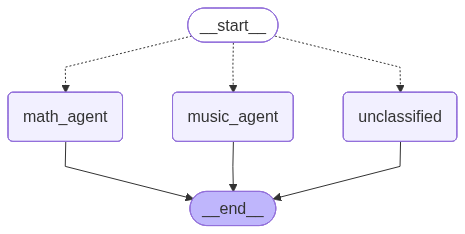

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Example Request Execution

Let's test our multi-agent system with some example queries!

### Example 1: Math Query
Testing the Math Agent with a Fibonacci number calculation.

In [13]:
example_1 = {
    "user_input": "What is fibonacci of 8?",
    "result": None
}


result_1 = graph.invoke(example_1)
result_1


 ROUTER CALLED
   INPUT: 'What is fibonacci of 8?'
   DECISION: math_agent

 MATH AGENT CALLED
   INPUT: 'What is fibonacci of 8?'
🔧 TOOL CALLED: compute_fibonacci
   INPUT: n = 8
   OUTPUT: {'status': 'success', 'result': 'The 8th Fibonacci number is 21'}
   RESPONSE: Fibonacci(8) = 21


{'user_input': 'What is fibonacci of 8?', 'result': 'Fibonacci(8) = 21'}

### Example 2: Music Query
Testing the Music Agent with a song lookup.

In [14]:
example_2 = {
    "user_input": "Who is the singer of yesterday?",
}


result_2 = graph.invoke(example_2)
result_2


 ROUTER CALLED
   INPUT: 'Who is the singer of yesterday?'
   DECISION: music_agent

 MUSIC AGENT CALLED
   INPUT: 'Who is the singer of yesterday?'
🔧 TOOL CALLED: lookup_song_artist
   INPUT: song_name = 'Yesterday'
   OUTPUT: The Beatles
   RESPONSE: "Yesterday" is by The Beatles. The lead vocal on the recording was sung by Paul McCartney.


{'user_input': 'Who is the singer of yesterday?',
 'result': '"Yesterday" is by The Beatles. The lead vocal on the recording was sung by Paul McCartney.'}

## Edge Case Examples

Testing how the system handles challenging scenarios

### Example 3: Unknown Song
Testing how the Music Agent handles songs not in the database.

In [15]:
edge_case_example_1 = {
    "user_input": "Who is the singer of 'The Loneliest'?",
    "result": None
}


edge_case_result_1 = graph.invoke(edge_case_example_1)
edge_case_result_1


 ROUTER CALLED
   INPUT: 'Who is the singer of 'The Loneliest'?'
   DECISION: music_agent

 MUSIC AGENT CALLED
   INPUT: 'Who is the singer of 'The Loneliest'?'
🔧 TOOL CALLED: lookup_song_artist
   INPUT: song_name = 'The Loneliest'
   OUTPUT: Unknown Song
   RESPONSE: Sorry — I don't have that song in my database and don't know who sings "The Loneliest."


{'user_input': "Who is the singer of 'The Loneliest'?",
 'result': 'Sorry — I don\'t have that song in my database and don\'t know who sings "The Loneliest."'}

### Example 4: Out of scope question
Testing how the Music Agent handles songs not in the database.

In [16]:
edge_case_example_2 = {
    "user_input": "Who is the main actor of film 'A Beautiful mind'?",
    "result": None
}


edge_case_result_2 = graph.invoke(edge_case_example_2)

edge_case_result_2


 ROUTER CALLED
   INPUT: 'Who is the main actor of film 'A Beautiful mind'?'
   DECISION: unclassified
   RESPONSE: I'm not sure how to help with that.


{'user_input': "Who is the main actor of film 'A Beautiful mind'?",
 'result': "I'm not sure how to help with that."}